In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import gcsfs
from tqdm.autonotebook import tqdm
from scipy import signal

/srv/conda/envs/notebook/lib/python3.7/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
# Experiments to process
experiment_ids = ['historical', 'ssp370']
experiment_ids1 = ['historical']

# Seasons to process
seasons = ['all','DJF','JJA']

# Time slices (future) to process
time_slices = ([#['1991','2020'],
                #['2001','2030'],
                ['2011','2040'],
                ['2021','2050'],
                ['2031','2060'],
                ['2041','2070'],
                ['2051','2080'],
                ['2061','2090'],
                ['2071','2100']])

In [3]:
# Read data locations
df = pd.read_csv('https://storage.googleapis.com/pangeo-cmip6/pangeo-cmip6-zarr-consolidated-stores.csv')

In [4]:
# Subset to monthly precipitation (let's just look at one run per model for now)
df_mon_pr = (df[((df.table_id == 'Amon') 
                 & (df.variable_id == 'pr')
                 & (df.member_id == "r1i1p1f1"))])

In [5]:
# Get names of all the models in the subset
pr_source_ids = []
for name, group in df_mon_pr.groupby('source_id'):
    if all([expt in group.experiment_id.values
            for expt in experiment_ids]):
        pr_source_ids.append(name)

In [6]:
# Subset to monthly tas (let's just look at one run per model for now)
df_mon_tas = (df[((df.table_id == 'Amon') 
                 & (df.variable_id == 'tas')
                 & (df.member_id == "r1i1p1f1"))])

In [7]:
# Get names of all the models in the subset
tas_source_ids = []
for name, group in df_mon_tas.groupby('source_id'):
    if all([expt in group.experiment_id.values
            for expt in experiment_ids]):
        tas_source_ids.append(name)

In [8]:
# Get names of all the models in the subset
df_areacella = (df[((df.table_id == 'fx') 
                 & (df.variable_id == 'areacella')
                 & (df.member_id == "r1i1p1f1"))])

areacella_source_ids = []
for name, group in df_areacella.groupby('source_id'):
    if all([expt in group.experiment_id.values
            for expt in experiment_ids1]):
        areacella_source_ids.append(name)
areacella_source_ids

['CESM2',
 'CESM2-WACCM',
 'CanESM5',
 'E3SM-1-0',
 'GFDL-CM4',
 'GFDL-ESM4',
 'IPSL-CM6A-LR',
 'MCM-UA-1-0',
 'MIROC6',
 'MRI-ESM2-0',
 'SAM0-UNICON']

In [9]:
tas_source_ids

['BCC-CSM2-MR',
 'BCC-ESM1',
 'CAMS-CSM1-0',
 'CESM2',
 'CESM2-WACCM',
 'CanESM5',
 'GFDL-ESM4',
 'IPSL-CM6A-LR',
 'MIROC6',
 'MRI-ESM2-0']

In [10]:
pr_source_ids

['BCC-CSM2-MR',
 'BCC-ESM1',
 'CAMS-CSM1-0',
 'CESM2',
 'CESM2-WACCM',
 'CanESM5',
 'FGOALS-g3',
 'GFDL-ESM4',
 'IPSL-CM6A-LR',
 'MIROC6',
 'MRI-ESM2-0']

In [11]:
source_ids=list(set(tas_source_ids).intersection(pr_source_ids))
source_ids

['MIROC6',
 'CESM2',
 'BCC-CSM2-MR',
 'MRI-ESM2-0',
 'CanESM5',
 'IPSL-CM6A-LR',
 'CAMS-CSM1-0',
 'GFDL-ESM4',
 'BCC-ESM1',
 'CESM2-WACCM']

In [12]:
source_ids_areacella=list(set(tas_source_ids).intersection(pr_source_ids).intersection(areacella_source_ids))
source_ids_areacella

['MIROC6',
 'CESM2',
 'MRI-ESM2-0',
 'CanESM5',
 'IPSL-CM6A-LR',
 'GFDL-ESM4',
 'CESM2-WACCM']

In [13]:
# Function to load data: df_data has the catalogue of the variable of interest
def load_data(df_data, source_id, expt_id):
    """
    Load data for given variable, source and expt ids.
    """
    uri = df_data[(df_data.source_id == source_id) &
                  (df_data.experiment_id == expt_id)].zstore.values[0]
    
    gcs = gcsfs.GCSFileSystem(token='anon')
    ds = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
    return ds

In [14]:
# # Function to load precipitation data
# def load_tas_data(source_id, expt_id):
#     """
#     Load tas data for given source and expt ids
#     """
#     uri = df_mon_tas[(df_mon_tas.source_id == source_id) &
#                          (df_mon_tas.experiment_id == expt_id)].zstore.values[0]
    
#     gcs = gcsfs.GCSFileSystem(token='anon')
#     ds = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
#     return ds

In [15]:
# Function to get mean and variability and their changes
def mean_dtas_calc(data_tmp,seas='all', weights_in=None):
    # Set if season is 'all'
    if seas=="all":
        seas = ['DJF','MAM','JJA','SON']
    
    # Load
    mu_hist = data_tmp['hist'].load()
    mu_futr = data_tmp['futr'].load()
    
        
    # Calculate mean of raw series
    mu_hist = (data_tmp['hist'].sel(time=data_tmp['hist'].time.dt.season.isin(seas))
               .tas.mean('time'))
    mu_futr = (data_tmp['futr'].sel(time=data_tmp['futr'].time.dt.season.isin(seas))
               .tas.mean('time'))
    if weights_in is not None:
        weights = weights_in.areacella
        mu_histG = np.average(mu_hist,weights=weights)
        mu_futrG = np.average(mu_futr,weights=weights)
    else:
        # Area weighting
        latr = np.deg2rad(data_tmp['hist'].lat)
        # Use the cosine of the converted latitudes as weights for the average
        weights = np.cos(latr)
        mu_histG = np.average(mu_hist.mean("lon"),weights=weights)
        mu_futrG = np.average(mu_futr.mean("lon"),weights=weights)
        
    dtasG = mu_futrG-mu_histG
#    dmu = mu_futr/mu_hist
#    dmuG = np.average(dmu.mean("lon"),weights=weights.values)

    # Out 
    outp = xr.Dataset(
        data_vars = {#'tas_hist': tas_hist,
                     #'tas_futr': tas_futr,
                     #'dmu':     dmu,
                     'dtasG':    ([],dtasG)}

        #coords={'lon':            (['lon'],results_tmp['hist'].lon),
        #        'lat':             (['lat'],results_tmp['hist'].lat)}
        )


    return(outp)

In [45]:

tdata = {}
tresults = {}

for mod_name in tqdm(source_ids):
    # get a 20 year period
    # try:
        print('\n\nStarting '+mod_name+'\n')
        ds_hist = load_data(df_mon_tas, mod_name, experiment_ids[0]).sel(time=slice('1976', '2005'))
        ds_ssp  = load_data(df_mon_tas, mod_name, experiment_ids[1])
        
        try: # try getting areacella data
            ds_areacella = load_data(df_areacella, mod_name, experiment_ids[0])

        except: #if not available, flag it as 0. It will use np.cos(lat)
            ds_areacella = None
        
        tdata[mod_name] = {}
        tresults[mod_name] = {}
        
        for time_slice in time_slices:
            print('Begin processing time slice '+time_slice[0]+'-'+time_slice[1])
            if ds_ssp.time.max().dt.year+1<int(time_slice[1]):
                print("Future time series only goes until "+str(ds_ssp.time.max().dt.year.values))
                break
            
            # Get corresponding temporal slice of data and stage it
            ds_ssp_tmp = ds_ssp.sel(time=slice(time_slice[0],time_slice[1]))
            tdata[mod_name]["t"+time_slice[0]] = {'hist':ds_hist,'futr':ds_ssp_tmp}
            
            
            tresults[mod_name]["t"+time_slice[0]] = {}
           # Calculate means, sds,...
            tresults[mod_name]['t'+time_slice[0]] = mean_dtas_calc(tdata[mod_name]['t'+time_slice[0]],
                                                                   seas = 'all', weights_in=ds_areacella)
            print(' processed!')
                
            print(time_slice[0]+'-'+time_slice[1]+' processed!')
            
        print(mod_name+' processed!')
    #except:
    #    print(mod_name+"broken")



Starting BCC-ESM1

Begin processing time slice 2011-2040
 processed!
2011-2040 processed!
Begin processing time slice 2021-2050
 processed!
2021-2050 processed!
Begin processing time slice 2031-2060
Future time series only goes until 2055
BCC-ESM1 processed!


Starting CanESM5

Begin processing time slice 2011-2040
 processed!
2011-2040 processed!
Begin processing time slice 2021-2050
 processed!
2021-2050 processed!
Begin processing time slice 2031-2060
 processed!
2031-2060 processed!
Begin processing time slice 2041-2070
 processed!
2041-2070 processed!
Begin processing time slice 2051-2080
 processed!
2051-2080 processed!
Begin processing time slice 2061-2090
 processed!
2061-2090 processed!
Begin processing time slice 2071-2100
 processed!
2071-2100 processed!
CanESM5 processed!


Starting GFDL-ESM4

Begin processing time slice 2011-2040
 processed!
2011-2040 processed!
Begin processing time slice 2021-2050
 processed!
2021-2050 processed!
Begin processing time slice 2031-2060
 

In [46]:
pd.DataFrame(tresults)

,BCC-ESM1,CanESM5,GFDL-ESM4,CAMS-CSM1-0,IPSL-CM6A-LR,CESM2-WACCM,BCC-CSM2-MR,MIROC6,CESM2,MRI-ESM2-0
t2011,[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG]
t2021,[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG]
t2031,NaN,[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG]
t2041,NaN,[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG]
t2051,NaN,[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG]
t2061,NaN,[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG]
t2071,NaN,[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG]


In [47]:
tresults_new=tresults
for model in tresults:
    for timeperiod in tresults[model]:
        tresults_new[model][timeperiod]=tresults_new[model][timeperiod].dtasG.values.item(0)


In [48]:
tresults_new

{'BCC-ESM1': {'t2011': 1.0801761490631065, 't2021': 1.2820887939342356},
 'CanESM5': {'t2011': 1.43841552734375,
  't2021': 1.863525390625,
  't2031': 2.394561767578125,
  't2041': 2.99609375,
  't2051': 3.5789794921875,
  't2061': 4.184478759765625,
  't2071': 4.7864990234375},
 'GFDL-ESM4': {'t2011': 0.812835693359375,
  't2021': 1.0216064453125,
  't2031': 1.295166015625,
  't2041': 1.63104248046875,
  't2051': 2.001800537109375,
  't2061': 2.39813232421875,
  't2071': 2.761627197265625},
 'CAMS-CSM1-0': {'t2011': 0.5855764510201311,
  't2021': 0.772981770688375,
  't2031': 0.9939430476181315,
  't2041': 1.2723319490262384,
  't2051': 1.5313122272233954,
  't2061': 1.8341181418410883,
  't2071': 2.1015741747082757},
 'IPSL-CM6A-LR': {'t2011': 1.021453857421875,
  't2021': 1.34625244140625,
  't2031': 1.789947509765625,
  't2041': 2.24884033203125,
  't2051': 2.722991943359375,
  't2061': 3.22271728515625,
  't2071': 3.82684326171875},
 'CESM2-WACCM': {'t2011': 1.0078125,
  't2021': 

In [49]:
pd.DataFrame(tresults_new).to_csv('tresults.csv')

In [50]:
tresults_new=pd.read_csv('tresults.csv',index_col=0)
tresults_new

,BCC-ESM1,CanESM5,GFDL-ESM4,CAMS-CSM1-0,IPSL-CM6A-LR,CESM2-WACCM,BCC-CSM2-MR,MIROC6,CESM2,MRI-ESM2-0
t2011,1.080176,1.438416,0.812836,0.585576,1.021454,1.007812,0.964405,0.697571,1.094421,1.023926
t2021,1.282089,1.863525,1.021606,0.772982,1.346252,1.271332,1.241890,0.924072,1.337646,1.267822
t2031,NaN,2.394562,1.295166,0.993943,1.789948,1.642242,1.599642,1.235840,1.657043,1.614258
t2041,NaN,2.996094,1.631042,1.272332,2.248840,2.098663,1.969405,1.533264,2.027405,1.980377
t2051,NaN,3.578979,2.001801,1.531312,2.722992,2.548523,2.325534,1.861328,2.485107,2.343811
t2061,NaN,4.184479,2.398132,1.834118,3.222717,3.027191,2.711012,2.143311,3.025238,2.689697
t2071,NaN,4.786499,2.761627,2.101574,3.826843,3.494812,3.085562,2.475281,3.541107,3.042175


In [51]:
tresults_dict=tresults_new.to_dict()

In [52]:
dt=np.zeros((len(time_slices),len(tresults_dict)))*np.nan 

In [53]:
modelcount=0
modelnames=[]
for model in tresults_dict:
    modelnames.append(model)
    timecount=0
    for timeperiod in tresults_dict[model]:
        dt[timecount,modelcount]=tresults_dict[model][timeperiod]
        timecount=timecount+1
    modelcount=modelcount+1

In [54]:
dt

array([[1.08017615, 1.43841553, 0.81283569, 0.58557645, 1.02145386,
        1.0078125 , 0.96440512, 0.6975708 , 1.09442139, 1.02392578],
       [1.28208879, 1.86352539, 1.02160645, 0.77298177, 1.34625244,
        1.27133179, 1.24188957, 0.92407227, 1.33764648, 1.26782227],
       [       nan, 2.39456177, 1.29516602, 0.99394305, 1.78994751,
        1.64224243, 1.59964209, 1.23583984, 1.65704346, 1.61425781],
       [       nan, 2.99609375, 1.63104248, 1.27233195, 2.24884033,
        2.09866333, 1.96940471, 1.53326416, 2.02740479, 1.9803772 ],
       [       nan, 3.57897949, 2.00180054, 1.53131223, 2.72299194,
        2.54852295, 2.32553355, 1.86132812, 2.48510742, 2.34381104],
       [       nan, 4.18447876, 2.39813232, 1.83411814, 3.22271729,
        3.02719116, 2.71101181, 2.14331055, 3.02523804, 2.68969727],
       [       nan, 4.78649902, 2.7616272 , 2.10157417, 3.82684326,
        3.49481201, 3.08556153, 2.47528076, 3.54110718, 3.04217529]])

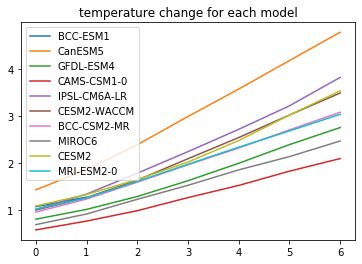

In [55]:
plt.plot(dt)
plt.title('temperature change for each model')
plt.legend(modelnames)

In [56]:
# # Function to load precipitation data
# def load_pr_data(source_id, expt_id):
#     """
#     Load precip data for given source and expt ids
#     """
#     uri = df_mon_pr[(df_mon_pr.source_id == source_id) &
#                          (df_mon_pr.experiment_id == expt_id)].zstore.values[0]
    
#     gcs = gcsfs.GCSFileSystem(token='anon')
#     ds = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
#     return ds

In [57]:
# # Function to get mean and variability and their changes
# def mean_var_calc_old(data_tmp,seas='all'):
#     # Set if season is 'all'
#     if seas=="all":
#         seas = ['DJF','MAM','JJA','SON']
    
#     # Load
#     mu_hist = data_tmp['hist'].load()
#     mu_futr = data_tmp['futr'].load()
    
#     # Area weighting
#     latr = np.deg2rad(data_tmp['hist'].lat)
#     # Use the cosine of the converted latitudes as weights for the average
#     weights = np.cos(latr)

#     # Calculate mean of raw series
#     mu_hist = (data_tmp['hist'].sel(time=data_tmp['hist'].time.dt.season.isin(seas))
#                .pr.mean('time'))
#     mu_futr = (data_tmp['futr'].sel(time=data_tmp['futr'].time.dt.season.isin(seas))
#                .pr.mean('time'))
#     mu_histG = np.average(mu_hist.mean("lon"),weights=weights.values)
#     mu_futrG = np.average(mu_futr.mean("lon"),weights=weights.values)
#     dmuG = mu_futrG/mu_histG
# #    dmu = mu_futr/mu_hist
# #    dmuG = np.average(dmu.mean("lon"),weights=weights.values)

#     # Calculate standard deviation of detrended series
#     sd_hist = (xr.apply_ufunc(signal.detrend, data_tmp['hist'].fillna(0),
#                                     kwargs={'axis': 0}).where(~data_tmp['hist'].isnull())
#                .sel(time=data_tmp['hist'].time.dt.season.isin(seas))
#                .std("time"))
#     sd_futr = (xr.apply_ufunc(signal.detrend, data_tmp['futr'].fillna(0),
#                                     kwargs={'axis': 0}).where(~data_tmp['futr'].isnull())
#                .sel(time=data_tmp['futr'].time.dt.season.isin(seas))
#                .std("time"))
#     var_hist = sd_hist ** 2
#     var_histG = np.average(var_hist.mean("lon").pr,weights=weights.values)
#     sd_histG = np.sqrt(var_histG)
#     var_futr = sd_futr ** 2
#     var_futrG = np.average(var_futr.mean("lon").pr,weights=weights.values)
#     sd_futrG = np.sqrt(var_futrG)
#     dsd = sd_futr/sd_hist
#     dsdG = sd_futrG/sd_histG

#     # Out 
#     outp = xr.Dataset(
#         data_vars = {'mu_hist': mu_hist,
#                      'mu_futr': mu_futr,
#                      #'dmu':     dmu,
#                      'dmuG':    ([],dmuG),
#                      'sd_hist': sd_hist.pr,
#                      'sd_futr': sd_futr.pr,
#                      #'dsd':     dsd.pr,
#                      'dsdG':    ([],dsdG)},
#         #coords={'lon':            (['lon'],results_tmp['hist'].lon),
#         #        'lat':             (['lat'],results_tmp['hist'].lat)}
#         )


#     return(outp)

In [ ]:
# data = {}
# results = {}

# for mod_name in tqdm(source_ids):
#     # get a 20 year period
#     # try:
#         print('\n\nStarting '+mod_name+'\n')
#         ds_hist = load_data(df_mon_pr, mod_name, experiment_ids[0]).sel(time=slice('1976', '2005'))
#         ds_ssp  = load_data(df_mon_pr, mod_name, experiment_ids[1])
        
#         data[mod_name] = {}
#         results[mod_name] = {}
        
#         for time_slice in time_slices:
#             print('Begin processing time slice '+time_slice[0]+'-'+time_slice[1])
#             if ds_ssp.time.max().dt.year+1<int(time_slice[1]):
#                 print("Future time series only goes until "+str(ds_ssp.time.max().dt.year.values))
#                 break
            
#             # Get corresponding temporal slice of data and stage it
#             ds_ssp_tmp = ds_ssp.sel(time=slice(time_slice[0],time_slice[1]))
#             data[mod_name]["t"+time_slice[0]] = {'hist':ds_hist,'futr':ds_ssp_tmp}
            
            
#             results[mod_name]["t"+time_slice[0]] = {}
#             for seas in seasons:
#                 # Calculate means, sds,...
#                 results[mod_name]['t'+time_slice[0]][seas] = mean_var_calc_old(data[mod_name]['t'+time_slice[0]],seas)
#                 print(seas+' processed!')
                
#             print(time_slice[0]+'-'+time_slice[1]+' processed!')
            
#         print(mod_name+' processed!')
#     #except:
#     #    print(mod_name+"broken")



Starting BCC-ESM1

Begin processing time slice 2011-2040
all processed!
DJF processed!
JJA processed!
2011-2040 processed!
Begin processing time slice 2021-2050
all processed!
DJF processed!
JJA processed!
2021-2050 processed!
Begin processing time slice 2031-2060
Future time series only goes until 2055
BCC-ESM1 processed!


Starting CanESM5

Begin processing time slice 2011-2040
all processed!
DJF processed!
JJA processed!
2011-2040 processed!
Begin processing time slice 2021-2050
all processed!
DJF processed!
JJA processed!
2021-2050 processed!
Begin processing time slice 2031-2060
all processed!
DJF processed!
JJA processed!
2031-2060 processed!
Begin processing time slice 2041-2070
all processed!
DJF processed!
JJA processed!
2041-2070 processed!
Begin processing time slice 2051-2080
all processed!
DJF processed!
JJA processed!
2051-2080 processed!
Begin processing time slice 2061-2090
all processed!
DJF processed!
JJA processed!
2061-2090 processed!
Begin processing time slice 2

In [16]:
# Function to get mean and variability and their changes
def mean_var_calc(data_tmp,seas='all',weights_in=None):
    print(weights_in)
    # Set if season is 'all'
    if seas=="all":
        seas = ['DJF','MAM','JJA','SON']
    
    # Load
    mu_hist = data_tmp['hist'].load()
    mu_futr = data_tmp['futr'].load()
    

    # Calculate mean of raw series
    mu_hist = (data_tmp['hist'].sel(time=data_tmp['hist'].time.dt.season.isin(seas))
               .pr.mean('time'))
    mu_futr = (data_tmp['futr'].sel(time=data_tmp['futr'].time.dt.season.isin(seas))
               .pr.mean('time'))
    
    # Calculate standard deviation of detrended series
    sd_hist = (xr.apply_ufunc(signal.detrend, data_tmp['hist'].fillna(0),
                                    kwargs={'axis': 0}).where(~data_tmp['hist'].isnull())
               .sel(time=data_tmp['hist'].time.dt.season.isin(seas))
               .std("time"))
    sd_futr = (xr.apply_ufunc(signal.detrend, data_tmp['futr'].fillna(0),
                                    kwargs={'axis': 0}).where(~data_tmp['futr'].isnull())
               .sel(time=data_tmp['futr'].time.dt.season.isin(seas))
               .std("time"))

    # Calculate variance
    var_hist = sd_hist ** 2
    var_futr = sd_futr ** 2
    

    # Area averaging #
    if weights_in is not None:
        print('G')
        weights = weights_in.areacella
        mu_histG = np.average(mu_hist,weights=weights)
        mu_futrG = np.average(mu_futr,weights=weights)
        var_histG = np.average(var_hist.pr,weights=weights)
        var_futrG = np.average(var_futr.pr,weights=weights)
    else:
        print('F')
        ## if areacella is not available
        ## Use the cosine of the converted latitudes as weights for the average
        latr = np.deg2rad(data_tmp['hist'].lat)
        weights = np.cos(latr)
        mu_histG = np.average(mu_hist.mean("lon"),weights=weights)
        mu_futrG = np.average(mu_futr.mean("lon"),weights=weights)
        var_histG = np.average(var_hist.mean("lon").pr,weights=weights)
        var_futrG = np.average(var_futr.mean("lon").pr,weights=weights)
        
    sd_histG = np.sqrt(var_histG)
    sd_futrG = np.sqrt(var_futrG)
    
    # calculate changes
    dmuG = mu_futrG/mu_histG
#    dmu = mu_futr/mu_hist
#    dmuG = np.average(dmu.mean("lon"),weights=weights.values)
    
    dsd = sd_futr/sd_hist
    dsdG = sd_futrG/sd_histG

    # Out 
    outp = xr.Dataset(
        data_vars = {'mu_hist': mu_hist,
                     'mu_futr': mu_futr,
                     #'dmu':     dmu,
                     'dmuG':    ([],dmuG),
                     'sd_hist': sd_hist.pr,
                     'sd_futr': sd_futr.pr,
                     #'dsd':     dsd.pr,
                     'dsdG':    ([],dsdG)},
        #coords={'lon':            (['lon'],results_tmp['hist'].lon),
        #        'lat':             (['lat'],results_tmp['hist'].lat)}
        )


    return(outp)

In [17]:
source_ids_areacella

['MIROC6',
 'CESM2',
 'MRI-ESM2-0',
 'CanESM5',
 'IPSL-CM6A-LR',
 'GFDL-ESM4',
 'CESM2-WACCM']

In [18]:

data = {}
results = {}

for mod_name in tqdm(source_ids):
    # get a 20 year period
    # try:
        print('\n\nStarting '+mod_name+'\n')
        ds_hist = load_data(df_mon_pr, mod_name, experiment_ids[0]).sel(time=slice('1976', '2005'))
        ds_ssp  = load_data(df_mon_pr, mod_name, experiment_ids[1])
        try: # try getting areacella data
            ds_areacella = load_data(df_areacella, mod_name, experiment_ids[0])

        except: #if not available, flag it as 0. It will use np.cos(lat)
            ds_areacella = None
        
        data[mod_name] = {}
        results[mod_name] = {}
        
        for time_slice in time_slices:
            print('Begin processing time slice '+time_slice[0]+'-'+time_slice[1])
            if ds_ssp.time.max().dt.year+1<int(time_slice[1]):
                print("Future time series only goes until "+str(ds_ssp.time.max().dt.year.values))
                break
            
           # Get corresponding temporal slice of data and stage it
            ds_ssp_tmp = ds_ssp.sel(time=slice(time_slice[0],time_slice[1]))
            data[mod_name]["t"+time_slice[0]] = {'hist':ds_hist,'futr':ds_ssp_tmp}
            
            
            results[mod_name]["t"+time_slice[0]] = {}
            for seas in seasons:
                # Calculate means, sds,...
                results[mod_name]['t'+time_slice[0]][seas] = mean_var_calc(data[mod_name]['t'+time_slice[0]],
                                                                           seas, weights_in = ds_areacella)
                print(seas+' processed!')
                
            print(time_slice[0]+'-'+time_slice[1]+' processed!')
            
        print(mod_name+' processed!')
    #except:
    #    print(mod_name+"broken")



Starting MIROC6

Begin processing time slice 2011-2040
<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 128, lon: 256)
Coordinates:
  * lat        (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(128, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(256, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    areacella  (lat, lon) float32 dask.array<chunksize=(128, 256), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    cmor_version:           3.3.2
    creation_date:          2019-02-18T05:05:20Z
    data_specs_version:     01.00.28
    experiment:             all-forcing simulation of the recent past
    experiment_id:         

In [19]:
source_ids_areacella

['MIROC6',
 'CESM2',
 'MRI-ESM2-0',
 'CanESM5',
 'IPSL-CM6A-LR',
 'GFDL-ESM4',
 'CESM2-WACCM']

In [20]:
#results

In [21]:
# this is rather brute force, sorry
# dmuG, dsdG - also for different seasons 
dsdG_djf=results.copy()
dsdG_jja=results.copy()
dmuG_djf=results.copy()
dmuG_jja=results.copy()
for model in results:
    for timeperiod in results[model]:
        dsdG_djf[model][timeperiod]=results[model][timeperiod]['DJF'].dsdG.values.item(0)
        dsdG_jja[model][timeperiod]=results[model][timeperiod]['JJA'].dsdG.values.item(0)
        dmuG_djf[model][timeperiod]=results[model][timeperiod]['DJF'].dmuG.values.item(0)
        dmuG_jja[model][timeperiod]=results[model][timeperiod]['JJA'].dmuG.values.item(0)
        


TypeError: 'float' object is not subscriptable

In [22]:
pd.DataFrame(dsdG_djf)

,MIROC6,CESM2,BCC-CSM2-MR,MRI-ESM2-0,CanESM5,IPSL-CM6A-LR,CAMS-CSM1-0,GFDL-ESM4,BCC-ESM1,CESM2-WACCM
t2011,1.00411,"{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his..."
t2021,"{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his..."
t2031,"{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...",NaN,"{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his..."
t2041,"{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...",NaN,"{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his..."
t2051,"{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...",NaN,"{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his..."
t2061,"{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...",NaN,"{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his..."
t2071,"{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...",NaN,"{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his..."


In [23]:
pd.DataFrame(dsdG_djf).to_csv('dsdG_djf.csv')

In [24]:
dsdG_djf_new=pd.read_csv('dsdG_djf.csv',index_col=0)
dsdG_djf_new

,MIROC6,CESM2,BCC-CSM2-MR,MRI-ESM2-0,CanESM5,IPSL-CM6A-LR,CAMS-CSM1-0,GFDL-ESM4,BCC-ESM1,CESM2-WACCM
t2011,1.0041091442108154,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 6...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 6...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...
t2021,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 6...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 6...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...
t2031,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 6...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,NaN,{'all': <xarray.Dataset>\nDimensions: (lat: 1...
t2041,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 6...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,NaN,{'all': <xarray.Dataset>\nDimensions: (lat: 1...
t2051,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 6...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,NaN,{'all': <xarray.Dataset>\nDimensions: (lat: 1...
t2061,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 6...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,NaN,{'all': <xarray.Dataset>\nDimensions: (lat: 1...
t2071,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 6...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,NaN,{'all': <xarray.Dataset>\nDimensions: (lat: 1...


In [25]:
dsdG_djf=dsdG_djf_new.to_dict()